In [ ]:
import torch
import os


# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

dataset_path = 'dataset/Corn'
output_path = 'pyg_dataset'
os.makedirs(output_path, exist_ok=True)

def image_to_graph(img_path, label, sigma=1.0, threshold=0.01, max_corners=500):
    img = io.imread(img_path)
    img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)
    coords = corner_peaks(corner_harris(img_tensor[0, 0].cpu().numpy()), min_distance=5, threshold_rel=threshold, num_peaks=max_corners)
    x = torch.tensor(coords, dtype=torch.float).view(-1, 2)
    edge_index = torch.combinations(torch.arange(x.size(0), dtype=torch.long)).t().contiguous()
    y = torch.tensor([label], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)

    return data

def build_dataset(dataset_path, output_path, sigma=1.0, threshold=0.01, max_corners=500):
    dataset = []
    class_folders = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    for label, class_folder in enumerate(class_folders):
        class_path = os.path.join(dataset_path, class_folder)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            data = image_to_graph(img_path, label, sigma, threshold, max_corners)
            dataset.append(data)
            plot_image_with_nodes(img_path, data)

    torch.save(dataset, os.path.join(output_path, 'pyg_dataset.pt'))


def plot_image_with_nodes(img_path, data):
    img = io.imread(img_path)
    G = nx.Graph()

    img_height, img_width = img.shape[:2]
    for i, (x, y) in enumerate(data.x.cpu().numpy()):
        x = max(0, min(x, img_width - 1))
        y = max(0, min(y, img_height - 1))
        G.add_node(i, pos=(x, y))

    for edge in data.edge_index.t().cpu().numpy():
        G.add_edge(edge[0], edge[1])
    plt.imshow(img)
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=False, node_size=10, node_color='r')

    plt.show()

if __name__ == '__main__':
    build_dataset(dataset_path, output_path)


In [2]:
import torch

In [3]:
cc= torch.load(r"C:\Users\au783153\Documents\OBM\CODES\HeathlandSpeciesClassifier\dataset\graphs\grid\train\9_12.pt")

In [4]:
cc

Data(x=[50176, 3], edge_index=[398724, 2], y=[1], image_features=[3, 224, 224])

In [ ]:
import torch
import os


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
dataset_path = 'dataset/train'

output_path = 'pyg_dataset'
os.makedirs(output_path, exist_ok=True)

def image_to_graph_grid(img_path, label, grid_size=10):
    img = io.imread(img_path)
    img_height, img_width = img.shape[:2]
    grid_x, grid_y = np.meshgrid(np.linspace(0, img_width - 1, grid_size), np.linspace(0, img_height - 1, grid_size))
    coords = np.column_stack((grid_x.flatten(), grid_y.flatten()))

    x = torch.tensor(coords, dtype=torch.float)
    edge_index = torch.combinations(torch.arange(x.size(0), dtype=torch.long)).t().contiguous()
    y = torch.tensor([label], dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, y=y)

    return data

def build_dataset_grid(dataset_path, output_path, grid_size=10):
    dataset = []
    class_folders = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    for label, class_folder in enumerate(class_folders):
        class_path = os.path.join(dataset_path, class_folder)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            data = image_to_graph_grid(img_path, label, grid_size)
            dataset.append(data)
            plot_image_with_nodes(img_path, data)

    torch.save(dataset, os.path.join(output_path, 'pyg_dataset_grid.pt'))

def plot_image_with_nodes(img_path, data):
    img = io.imread(img_path)
    G = nx.Graph()
    for i, (x, y) in enumerate(data.x.cpu().numpy()):
        G.add_node(i, pos=(x, y))
    for edge in data.edge_index.t().cpu().numpy():
        G.add_edge(edge[0], edge[1])
    plt.imshow(img)
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=False, node_size=10, node_color='r')
    plt.show()

if __name__ == '__main__':
    build_dataset_grid(dataset_path, output_path, grid_size=10)


In [ ]:

import torch
from skimage.feature import corner_harris, corner_peaks
from torch_geometric.data import Data
from torchvision import transforms
from skimage import io
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

dataset_path = 'dataset/Corn'

output_path = 'pyg_dataset'
os.makedirs(output_path, exist_ok=True)

# convert image to graph using both Harris corner detection and grid-based approach
def image_to_graph_combined(img_path, label, sigma=1.0, threshold=0.01, max_corners=500, grid_size=10):
    img = io.imread(img_path)
    img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)

    harris_coords = corner_peaks(corner_harris(img_tensor[0, 0].cpu().numpy()), min_distance=5, threshold_rel=threshold, num_peaks=max_corners)

    img_height, img_width = img.shape[:2]
    grid_x, grid_y = np.meshgrid(np.linspace(0, img_width - 1, grid_size), np.linspace(0, img_height - 1, grid_size))
    grid_coords = np.column_stack((grid_x.flatten(), grid_y.flatten()))

    coords = np.vstack((harris_coords, grid_coords))

    coords[:, 0] = np.clip(coords[:, 0], 0, img_width - 1)
    coords[:, 1] = np.clip(coords[:, 1], 0, img_height - 1)

    x = torch.tensor(coords, dtype=torch.float)
    edge_index = torch.combinations(torch.arange(x.size(0), dtype=torch.long)).t().contiguous()
    y = torch.tensor([label], dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, y=y)

    return data

def build_dataset_combined(dataset_path, output_path, sigma=1.0, threshold=0.01, max_corners=500, grid_size=10):
    dataset = []
    class_folders = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    for label, class_folder in enumerate(class_folders):
        class_path = os.path.join(dataset_path, class_folder)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            data = image_to_graph_combined(img_path, label, sigma, threshold, max_corners, grid_size)
            dataset.append(data)
            plot_image_with_nodes(img_path, data)

    torch.save(dataset, os.path.join(output_path, 'pyg_dataset_combined.pt'))

def plot_image_with_nodes(img_path, data):
    img = io.imread(img_path)
    G = nx.Graph()

    for i, (x, y) in enumerate(data.x.cpu().numpy()):
        G.add_node(i, pos=(x, y))
    for edge in data.edge_index.t().cpu().numpy():
        G.add_edge(edge[0], edge[1])
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=False, node_size=10, node_color='r', alpha=0.6, linewidths=0.5, edge_color='k')

    plt.imshow(img)
    plt.show()

if __name__ == '__main__':
    build_dataset_combined(dataset_path, output_path, sigma=1.0, threshold=0.01, max_corners=500, grid_size=10)


In [ ]:
import torch
data = torch.load("dataset/graphs/Corn0.pt")
for i in range(100,249):
    print(data[i])

In [57]:
import os
import torch
from skimage import io
from skimage.feature import corner_harris, corner_peaks
from torch_geometric.data import Data
from torchvision import transforms
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from skimage import color, feature, filters
from skimage.transform import resize


def image_to_graph(img_path, label, cnn_model=None, target_size=(224, 224)):
    img = io.imread(img_path)

    # Resize for CNN feature extraction
    img_resized = resize(img, target_size) if cnn_model else img
    img_tensor = transforms.ToTensor()(img_resized)

    # Harris Corner Detection
    coords = corner_peaks(corner_harris(img_tensor[0].numpy()), min_distance=5)

    # Initialize feature list
    features = []

    for x, y in coords:
        # Color features (RGB)
        rgb = img_tensor[:, int(y), int(x)].numpy()
        
        # Texture features (LBP)
        lbp = feature.local_binary_pattern(img_tensor[0], P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 11), range=(0, 10))
        lbp_hist = lbp_hist / np.sum(lbp_hist)

        # Image gradient
        grad_x, grad_y = np.gradient(img_tensor[0].numpy())
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        grad_dir = np.arctan2(grad_y, grad_x)
        grad_features = [grad_mag[int(y), int(x)], grad_dir[int(y), int(x)]]

        # CNN features
        if cnn_model:
            cnn_features = cnn_model(img_tensor.unsqueeze(0)).detach().numpy().flatten()
        else:
            cnn_features = []

        # Combine features
        node_features = np.concatenate((rgb, lbp_hist, grad_features, cnn_features))
        features.append(node_features)

    # Convert to tensor
    x = torch.tensor(features, dtype=torch.float)
    edge_index = torch.combinations(torch.arange(x.size(0), dtype=torch.long)).t().contiguous()

    return Data(x=x, edge_index=edge_index, y=label)

def get_classes(folder_path):
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    return {class_name: i for i, class_name in enumerate(classes)}

def plot_image_with_graph(img_path, data):
    # Load and plot the image
    img = io.imread(img_path)
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')

    # Plot the graph
    plt.subplot(122)
    G = nx.Graph()
    for i in range(data.x.shape[0]):
        G.add_node(i)
    for edge in data.edge_index.t().numpy():
        G.add_edge(edge[0], edge[1])
    pos = {i: data.x[i].numpy() for i in range(data.x.shape[0])}
    nx.draw(G, pos, node_size=50, node_color='red')
    plt.title('Graph Representation')

    plt.show()

# Example usage
img_folder = 'dataset/images/Corn0'
class_map = get_classes(img_folder)
num_classes = len(class_map)
graph_dataset = []

for class_folder in os.listdir(img_folder):
    class_path = os.path.join(img_folder, class_folder)
    class_label = class_map[class_folder]
    for img_file in os.listdir(class_path):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(class_path, img_file)
            graph_data = image_to_graph(img_path, class_label)
            graph_dataset.append(graph_data)
            plot_image_with_graph(img_path, graph_data)  # Optional: plot the first few

print("Number of classes:", num_classes)


TypeError: Cannot interpret 'torch.float32' as a data type

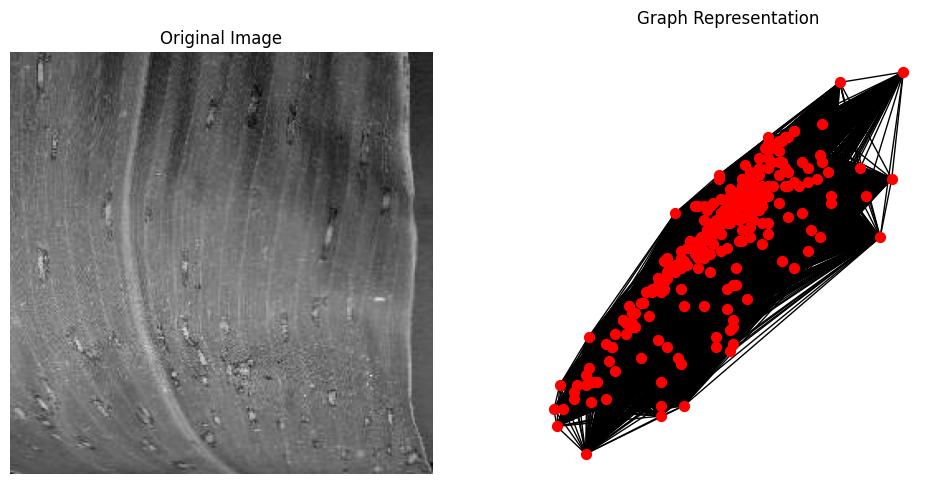

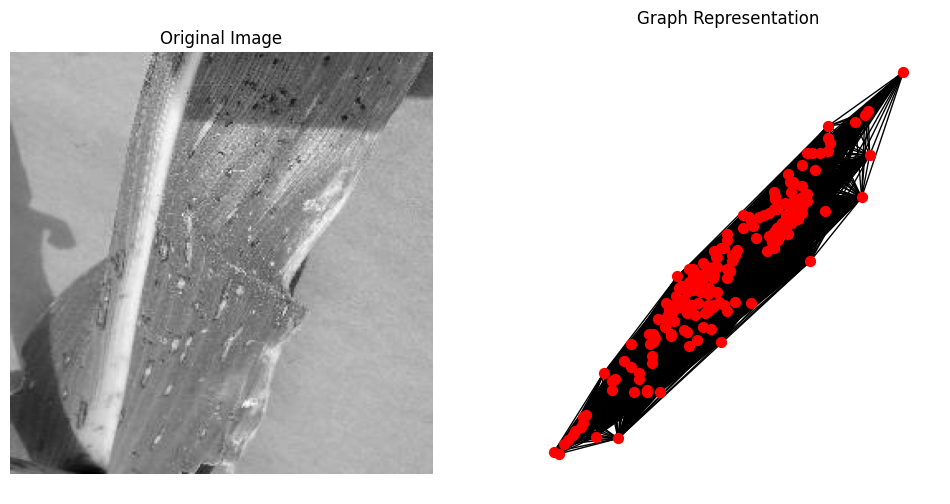

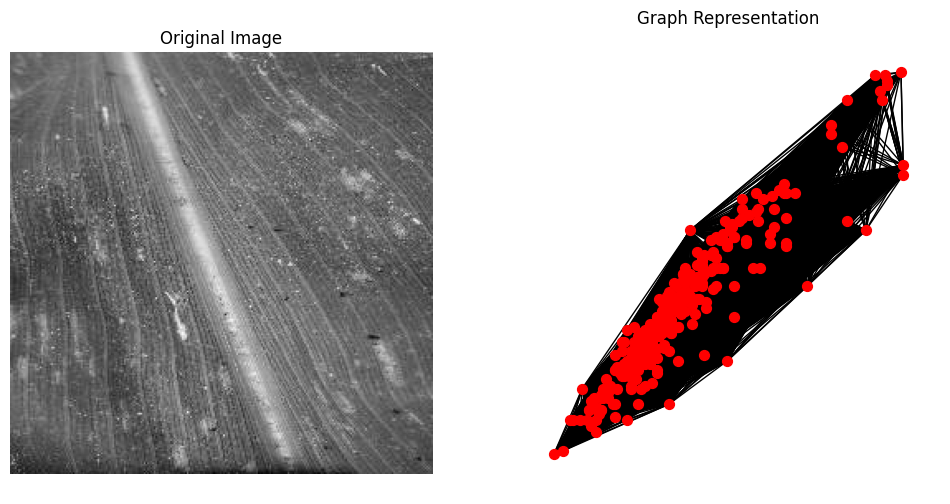

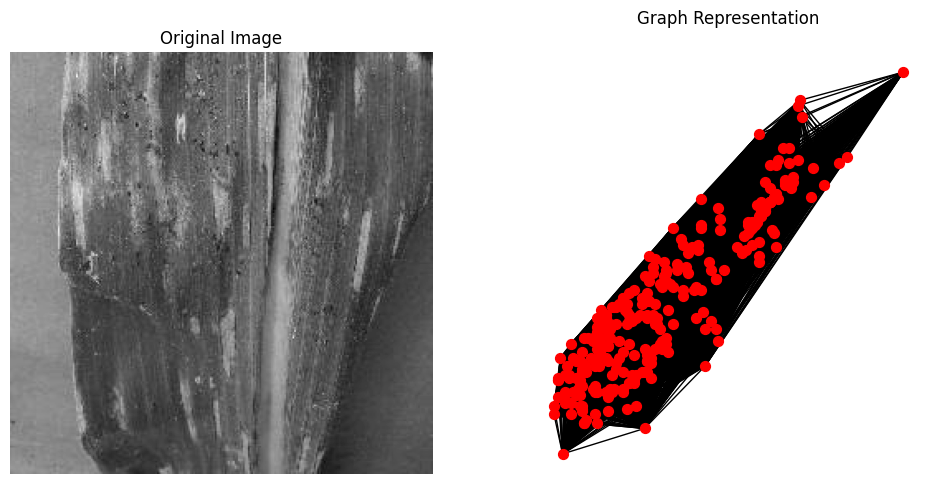

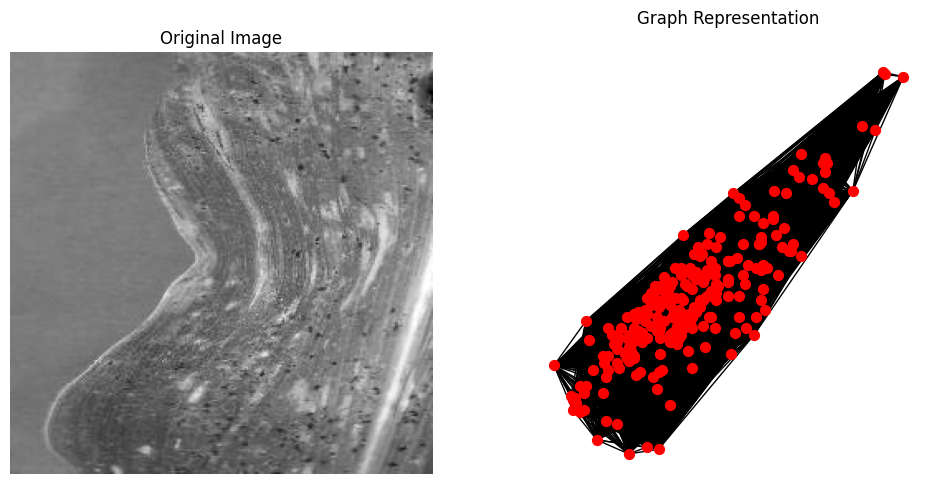

KeyboardInterrupt: 

In [58]:
import os
import torch
import numpy as np
from skimage import io, color, feature, filters
from skimage.transform import resize
from skimage.feature import corner_harris, corner_peaks
from torch_geometric.data import Data
from torchvision import transforms


import matplotlib.pyplot as plt
import networkx as nx

def plot_image_with_graph(img_path, data):
    # Load the image
    img = io.imread(img_path)

    # Ensure the image is in grayscale for easier visualization
    if len(img.shape) > 2:
        img = color.rgb2gray(img)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the original image
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot the graph
    G = nx.Graph()

    # Correcting the position format
    pos = {i: (data.x[i, 0].item(), data.x[i, 1].item()) for i in range(data.num_nodes)}

    G.add_nodes_from(pos.keys())
    for edge in data.edge_index.t().numpy():
        G.add_edge(edge[0], edge[1])
    nx.draw(G, pos, ax=axes[1], node_color='red', node_size=50, with_labels=False)
    axes[1].set_title('Graph Representation')
    axes[1].axis('off')

    plt.show()


def image_to_graph(img_path, label):
    img = io.imread(img_path)

    # Ensure the image is in RGB format
    if len(img.shape) == 2:
        img = color.gray2rgb(img)
    img_tensor = transforms.ToTensor()(img)

    # Harris Corner Detection
    coords = corner_peaks(corner_harris(img_tensor[0].numpy()), min_distance=5)

    # Initialize feature list
    features = []

    for x, y in coords:
        # Extract features (color, texture, gradient, etc.)
        # RGB Color Features
        rgb = img[int(y), int(x), :]

        # # Texture Features - Local Binary Pattern
        # lbp = feature.local_binary_pattern(img_tensor[0], P=8, R=1, method='uniform')
        # lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 11), range=(0, 10))
        # lbp_hist = lbp_hist / np.sum(lbp_hist)  # Normalize

        # Image Gradients
        grad_x, grad_y = np.gradient(img_tensor[0].numpy())
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        grad_dir = np.arctan2(grad_y, grad_x)
        grad_features = [grad_mag[int(y), int(x)], grad_dir[int(y), int(x)]]

        # Combine features
        # node_features = np.concatenate((rgb, lbp_hist, grad_features))
        node_features = np.concatenate((rgb, grad_features))
        node_features = np.array(node_features, dtype=np.float32)
        features.append(node_features)

    # Convert to tensor
    x = torch.tensor(np.stack(features), dtype=torch.float)
    edge_index = torch.combinations(torch.arange(x.size(0), dtype=torch.long)).t().contiguous()

    return Data(x=x, edge_index=edge_index, y=label)

# Example usage
class_map = get_classes(img_folder)
num_classes = len(class_map)
graph_dataset = []

for class_folder in os.listdir(img_folder):
    class_path = os.path.join(img_folder, class_folder)
    class_label = class_map[class_folder]
    for img_file in os.listdir(class_path):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(class_path, img_file)
            graph_data = image_to_graph(img_path, class_label)
            graph_dataset.append(graph_data)
            plot_image_with_graph(img_path, graph_data) 

print("Number of classes:", num_classes)


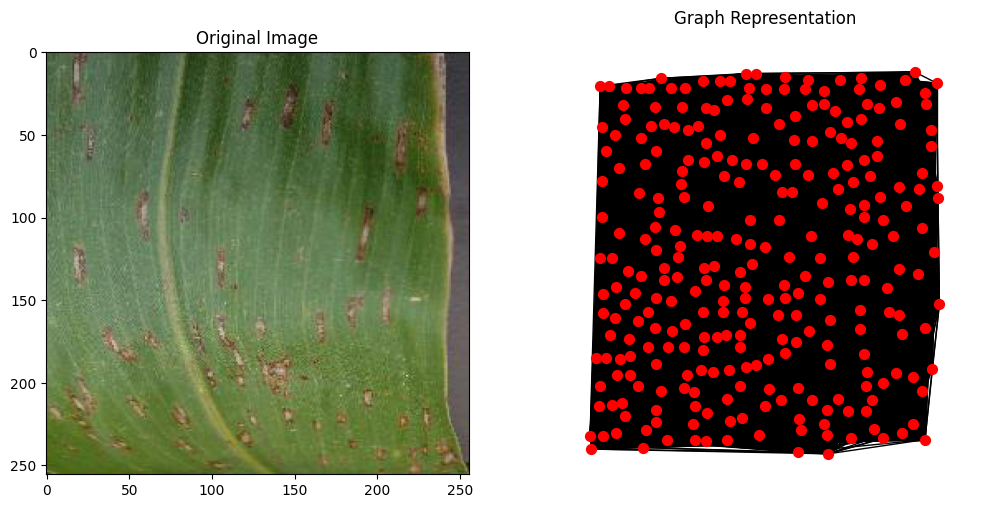

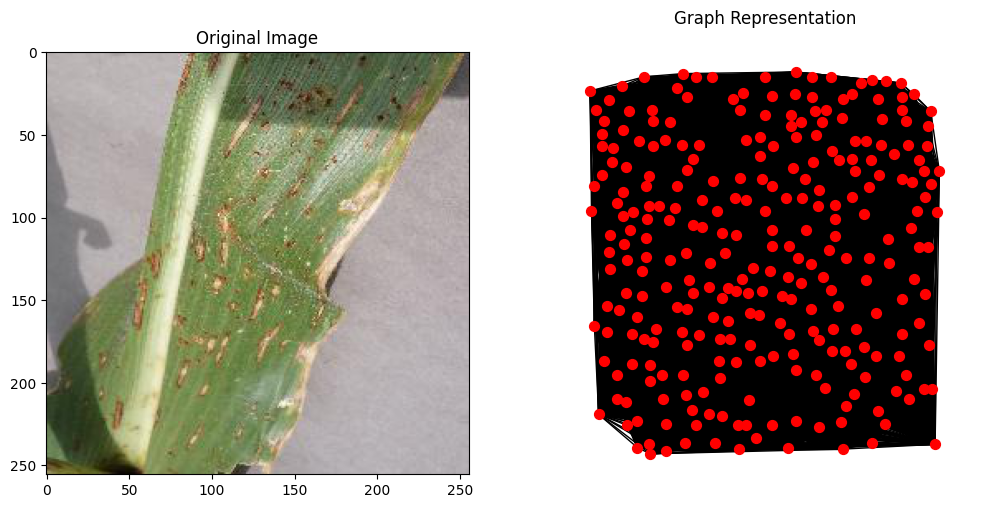

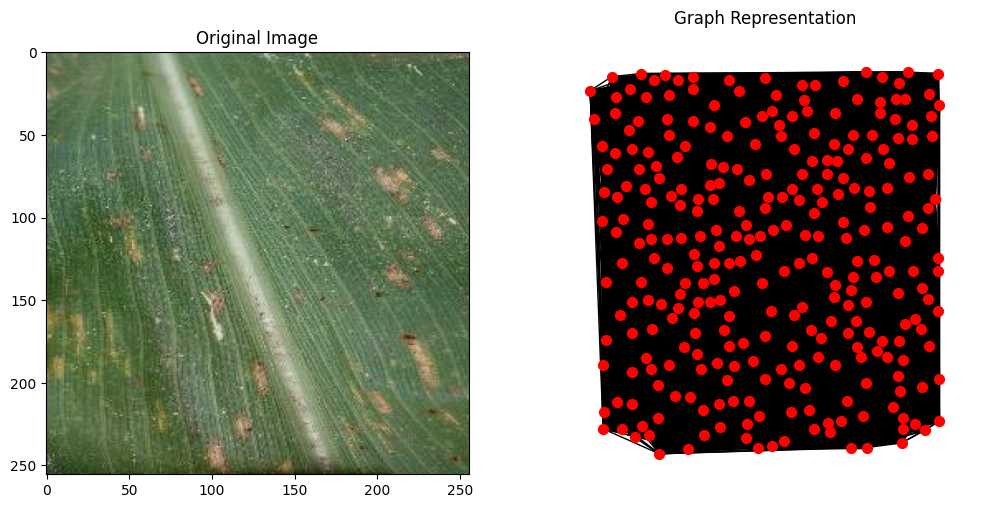

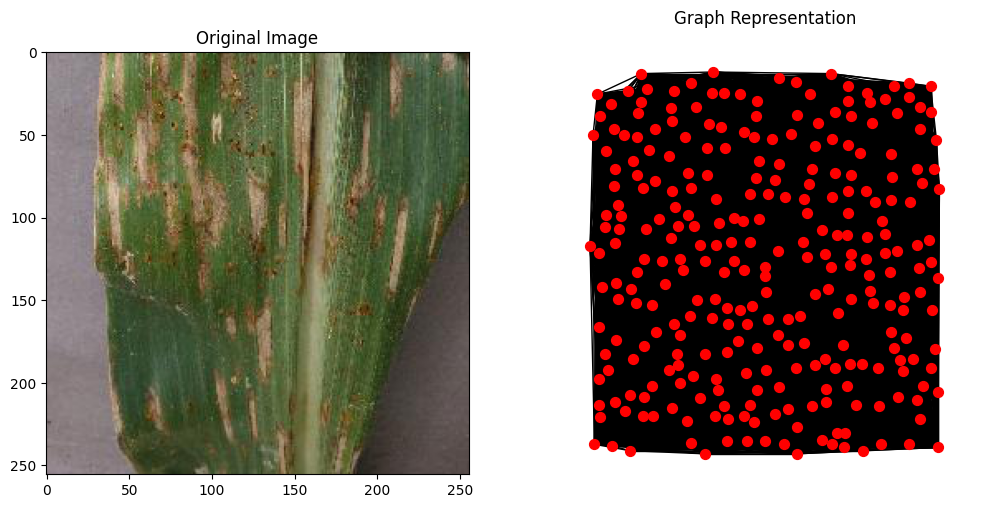

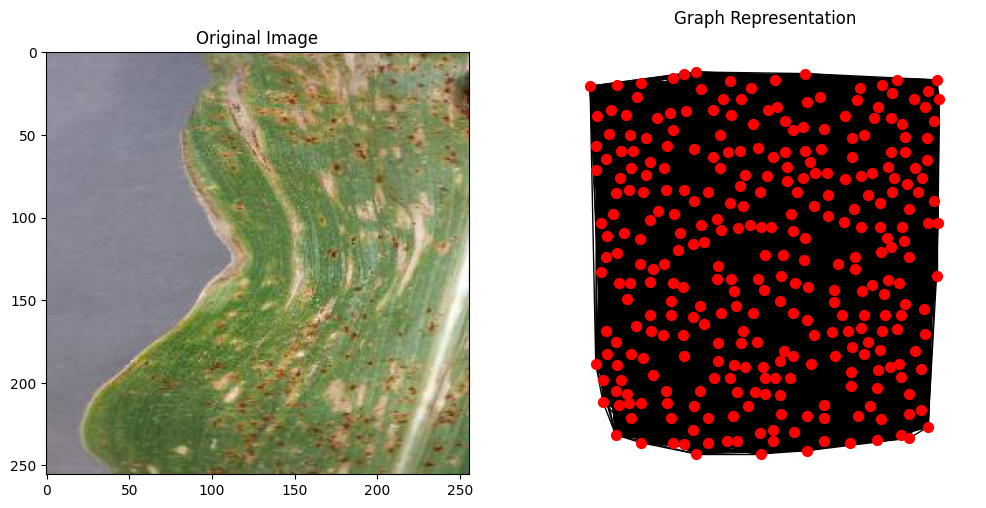

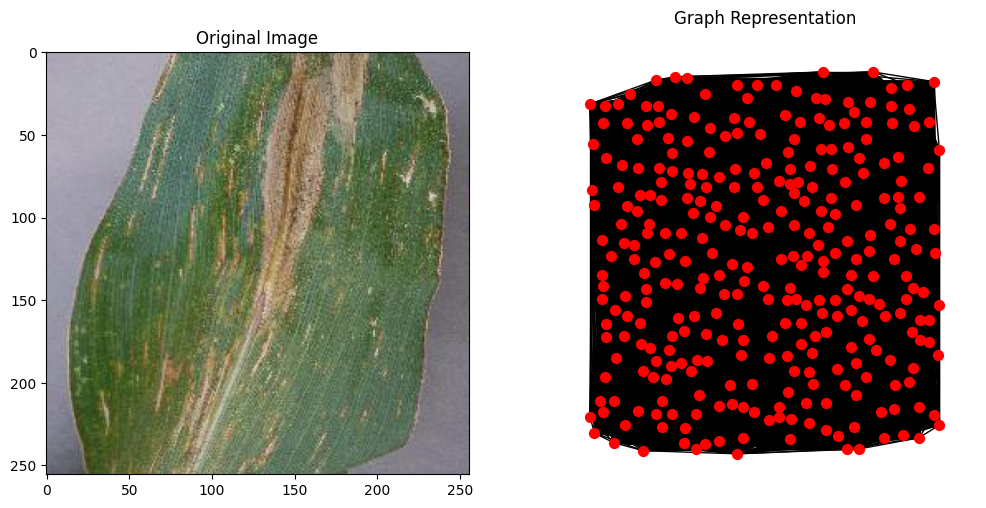

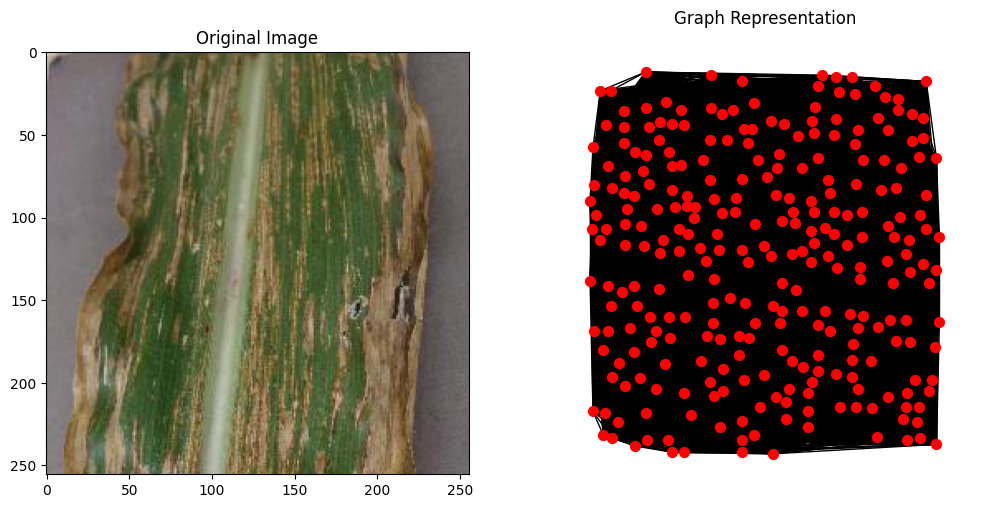

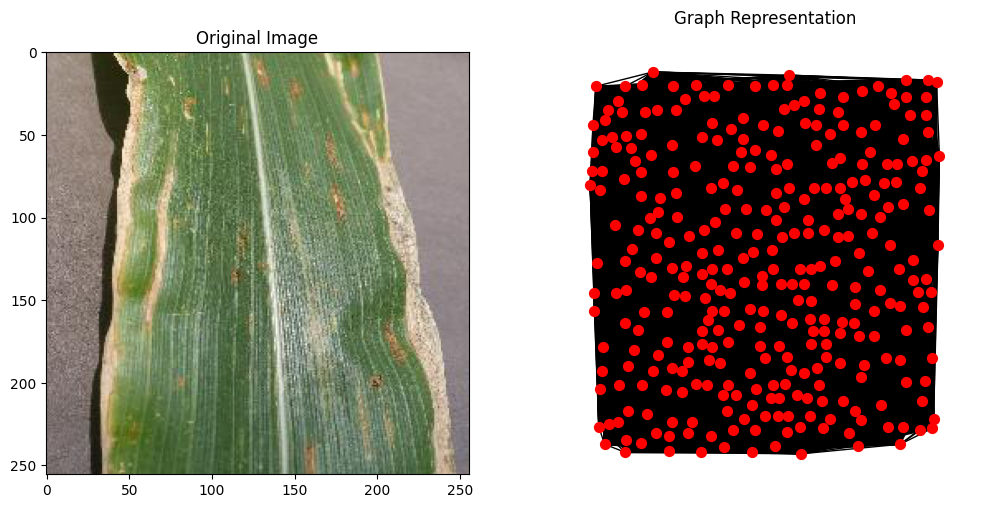

KeyboardInterrupt: 

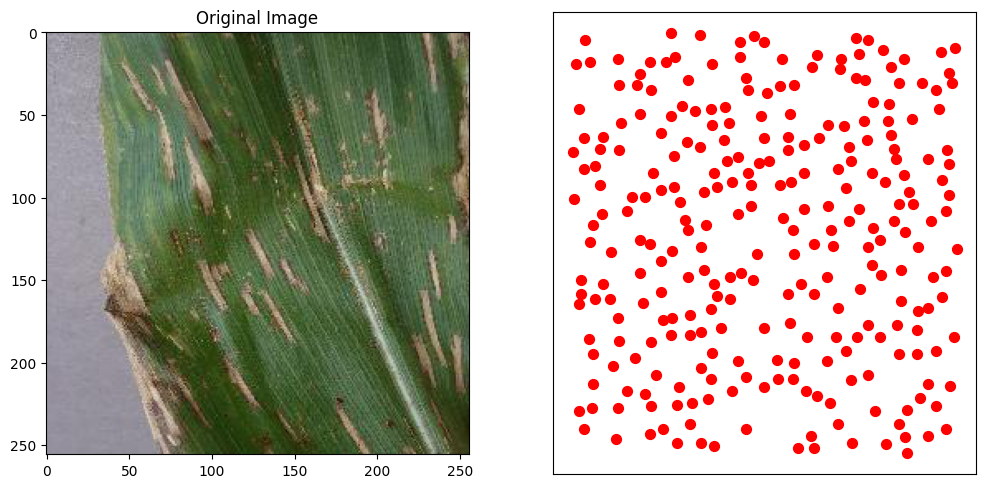

In [56]:
import os
import torch
from skimage import io
from skimage.feature import corner_harris, corner_peaks
from torch_geometric.data import Data
from torchvision import transforms
import matplotlib.pyplot as plt
import networkx as nx

def image_to_graph(img_path):
    # Read and process the image
    img = io.imread(img_path)
    img_tensor = transforms.ToTensor()(img)
    coords = corner_peaks(corner_harris(img_tensor[0].numpy()), min_distance=5)

    # Create graph nodes and edges
    x = torch.tensor(coords, dtype=torch.float)
    edge_index = torch.combinations(torch.arange(x.size(0), dtype=torch.long)).t().contiguous()

    # Create a dummy label (update this based on your dataset)
    y = torch.tensor([0], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)

def plot_image_with_graph(img_path, data):
    # Load and plot the image
    img = io.imread(img_path)
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')

    # Plot the graph
    plt.subplot(122)
    G = nx.Graph()
    for i in range(data.x.shape[0]):
        G.add_node(i)
    for edge in data.edge_index.t().numpy():
        G.add_edge(edge[0], edge[1])
    pos = {i: data.x[i].numpy() for i in range(data.x.shape[0])}
    nx.draw(G, pos, node_size=50, node_color='red')
    plt.title('Graph Representation')

    plt.show()

# Example usage
img_folder = 'dataset/images/Corn0'
graph_dataset = []

# Assuming each subfolder in the directory is a class
for class_folder in os.listdir(img_folder):
    class_path = os.path.join(img_folder, class_folder)
    for img_file in os.listdir(class_path):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(class_path, img_file)
            graph_data = image_to_graph(img_path)
            graph_dataset.append(graph_data)
            plot_image_with_graph(img_path, graph_data)  # Optional: plot the first few


In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load pre-trained DenseNet
densenet = models.densenet121(pretrained=True)

# Remove the classification layer to get feature extractor
densenet_feature_extractor = torch.nn.Sequential(*list(densenet.features.children()))

# Set DenseNet to evaluation mode
densenet_feature_extractor.eval()

# Load and preprocess the image
image_path = 'dataset/images/Corn1/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/de571dd2-b61a-488d-8c1a-c95b72720109___RS_GLSp 4647.JPG'  # Change this to your image path
image = Image.open(image_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image = preprocess(image).unsqueeze(0)  # Add batch dimension

# Extract features
with torch.no_grad():
    features = densenet_feature_extractor(image)

# Flatten the features to get a vector
features_vector = torch.flatten(features, start_dim=1)

# Output the size of the vector representation
print("Size of extracted features vector:", features_vector.size())


C:\Users\Bee\miniconda3\envs\dgnap\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Bee\miniconda3\envs\dgnap\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Size of extracted features vector: torch.Size([1, 50176])
